In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import yaml
import numpy as np


def dynamic_xu_xl(model_keys):
    assert len(model_keys) == 4
    with open("./configs.yaml", "r") as file:
        config = yaml.safe_load(file)
    xu = []
    xl = []
    for model_key in model_keys:
        model_name = config['model_conf'][model_key]
        xl.extend([config['xl'][model_name]['param1'], config['xl'][model_name]['param2']])
        xu.extend([config['xu'][model_name]['param1'], config['xu'][model_name]['param2']])
    
    xu[0] = 4
    xu[2] = 8
    xu[4] = 12
    xu[6] = 16
    return np.array(xl), np.array(xu)


In [2]:
from pymoo.core.individual import Individual
from pymoo.operators.sampling.rnd import FloatRandomSampling


import numpy as np
import time
class CustomIntegerRandomSampling(FloatRandomSampling):
    # def __init__(self, problem, n_samples, **kwargs):
    #     super().__init__()

    def _do(self, problem, n_samples, **kwargs):
        n = int(problem.n_var / 3)
        xl, xu = problem.bounds()
        xl = xl[0:n]
        xu = xu[0:n]
        with open("./configs.yaml", "r") as file:
            config = yaml.safe_load(file)
        X = np.column_stack([np.random.randint(config["model_key_xl"], config["model_key_xu"], size=n_samples) for _ in range(n)])
        full_solution = np.zeros((n_samples, problem.n_var))
        full_solution[:, :n] = X
        for i in range(n_samples):
            Dxl, Dxu = dynamic_xu_xl(X[i])
            dynamic_params = np.array([np.random.randint(Dxl[k], Dxu[k] + 1) for k in range(2*n)])
            full_solution[i, n:] = dynamic_params

        # Convert full_solution to array of Individuals using frompyfunc
        individuals = np.array([Individual(X=x) for x in full_solution])
        return full_solution


In [3]:
from pymoo.core.crossover import Crossover
from pymoo.util.misc import crossover_mask
import numpy as np
from pymoo.core.variable import Real, get



def repair_clamp(Xp, xl, xu):

    I = np.where(Xp < xl)
    c = np.sum(Xp < xl)
    Xp[I] = xl[I]

    I = np.where(Xp > xu)
    c += np.sum(Xp > xu)
    Xp[I] = xu[I]
    #print("lolcount")
    #print(c)

    return np.rint(Xp)


class UniformCrossoverv(Crossover):

    def __init__(self,
                 prob_var=1.0,
                 eta=15,
                 prob_exch=1.0,
                 prob_bin=0.5,
                 n_offsprings=1,
                 **kwargs):
        super().__init__(2, 1, **kwargs)
        #print("inint cross")
        self.prob_var = Real(prob_var, bounds=(0.1, 0.9))
        self.eta = Real(eta, bounds=(3.0, 30.0), strict=(1.0, None))
        self.prob_exch = Real(prob_exch, bounds=(0.0, 1.0), strict=(0.0, 1.0))
        self.prob_bin = Real(prob_bin, bounds=(0.0, 1.0), strict=(0.0, 1.0))

    def _do(self, _, X, **kwargs):
        #print("in croos")
        _, n_matings, n_var = X.shape
        n_var /= 3
        n_var = int(n_var)
        X_model_conf = X[:, :, :4]
        X_model_params = X[:, :, 4:]
        M = np.random.random((n_matings, n_var)) < 0.5
        _X_model_conf = crossover_mask(X_model_conf, M)
        xl_mat, xu_mat = np.empty((0, n_var * 2)), np.empty((0, n_var * 2))
        if self.n_offsprings == 1:
            rand = np.random.random(size=n_matings) < 0.5
            _X_model_conf[0, rand] = _X_model_conf[1, rand]
            _X_model_conf = _X_model_conf[[0]]
        for t in _X_model_conf :
            for conf in t:
                dynamic_xl, dynamic_xu = dynamic_xu_xl(conf)
                xl_mat = np.vstack([xl_mat, dynamic_xl])
                xu_mat = np.vstack([xu_mat, dynamic_xu])


        _, n_matings, _ = X_model_params.shape
        n_var *= 3
        # get the parameters required by SBX
        eta, prob_var, prob_exch, prob_bin = get(self.eta, self.prob_var, self.prob_exch, self.prob_bin, size=(n_matings, 1))

        # set the binomial probability to zero if no exchange between individuals shall happen
        rand = np.random.random((len(prob_bin), 1))
        prob_bin[rand > prob_exch] = 0.0
        #print("shape")
        #print(xl_mat.shape)
        Q = cross_sbx(X_model_params.astype(float), xl_mat, xu_mat, eta, prob_var, prob_bin)

        if self.n_offsprings == 1:
            rand = np.random.random(size=n_matings) < 0.5
            Q[0, rand] = Q[1, rand]
            Q = Q[[0]]

        #print("LOLL")
        #print(_X_model_conf.shape, Q.shape)
        #print("i am")
        return np.concatenate((_X_model_conf, Q), axis=-1)


def cross_sbx(X, xl, xu, eta, prob_var, prob_bin, eps=1.0e-14):
    n_parents, n_matings, n_var = X.shape

    # the probability of a crossover for each of the variables
    cross = np.random.random((n_matings, n_var)) < prob_var

    # when solutions are too close -> do not apply sbx crossover
    too_close = np.abs(X[0] - X[1]) <= eps

    # disable if two individuals are already too close
    cross[too_close] = False

    # disable crossover when lower and upper bound are identical
    # cross[:, xl == xu] = False

    # assign y1 the smaller and y2 the larger value
    y1 = np.min(X, axis=0)[cross]
    y2 = np.max(X, axis=0)[cross]

    # mask all the values that should be crossovered
    #print("xl")
    #print(xl.shape, cross.shape)
    _xl = xl[cross]
    _xu = xu[cross]
    eta = eta.repeat(n_var, axis=1)[cross]
    prob_bin = prob_bin.repeat(n_var, axis=1)[cross]
    #print(np.repeat(xl[None, :], n_matings, axis=0))
    # random values for each individual
    rand = np.random.random(len(eta))

    def calc_betaq(beta):
        epsilon = 1e-8  # A small value to avoid division by zero
        alpha = 2.0 - np.power(np.maximum(beta, epsilon), -(eta + 1.0))

        mask, mask_not = (rand <= (1.0 / alpha)), (rand > (1.0 / alpha))

        betaq = np.zeros(mask.shape)
        betaq[mask] = np.power(np.maximum((rand * alpha), 0.0), (1.0 / (eta + 1.0)))[mask]
        betaq[mask_not] = np.power((1.0 / (2.0 - rand * alpha)), (1.0 / (eta + 1.0)))[mask_not]

        return betaq

    # difference between all variables
    delta = (y2 - y1)

    beta = 1.0 + (2.0 * (y1 - _xl) / delta)
    betaq = calc_betaq(beta)
    c1 = 0.5 * ((y1 + y2) - betaq * delta)

    beta = 1.0 + (2.0 * (_xu - y2) / delta)
    betaq = calc_betaq(beta)
    c2 = 0.5 * ((y1 + y2) + betaq * delta)

    # with the given probability either assign the value from the first or second parent
    b = np.random.random(len(prob_bin)) < prob_bin
    tmp = np.copy(c1[b])
    c1[b] = c2[b]
    c2[b] = tmp

    # first copy the unmodified parents
    Q = np.copy(X)

    # copy the positions where the crossover was done
    Q[0, cross] = c1
    Q[1, cross] = c2

    Q[0] = repair_clamp(Q[0], xl, xu)
    Q[1] = repair_clamp(Q[1], xl, xu)

    return Q


In [4]:
import numpy as np
from pymoo.core.mutation import Mutation



class SwapIncrementalDecremenatalMutation(Mutation):
    def __init__(self, mutation_prob=0.1):
        super().__init__()
        self.mutation_prob = mutation_prob

    def _do(self, problem, X, **kwargs):
        Xp = np.copy(X)
        for gene in Xp :
            cur_prob = np.random.rand()
            if cur_prob > self.mutation_prob :
                continue

            a, b = np.random.choice(np.arange(0, 4), size=2, replace=False)

            gene[a], gene[b] = gene[b], gene[a]
            gene[a * 2 + 4], gene[b * 2 + 4] = gene[b * 2 + 4], gene[a * 2 + 4]
            gene[a * 2 + 5], gene[b * 2 + 5] = gene[b * 2 + 5], gene[a * 2 + 5]


            a, b = np.random.choice(np.arange(4, 12), size=2, replace=False)
            xl, xu = dynamic_xu_xl(gene[0:4])

            if np.random.randint(0, 2) == 0:
                gene[a] = (gene[a] + 1) % (xu[a - 4] - 1)
                gene[b] = (gene[b] + 1) % (xu[b - 4] - 1) 

            else :
                if gene[a] == xl[a - 5] :
                    gene[a] = xu[a - 5]
                else:
                    gene[a] = gene[a] - 1
                    
                if gene[b] == xl[b - 4] :
                    gene[b] = xu[b - 4]
                else:
                    gene[b] = gene[b] - 1
            
        return Xp


class SID(SwapIncrementalDecremenatalMutation):
    pass


In [6]:
import sys
import os

# Get the absolute path of archBuilderDir
arch_builder_path = os.path.abspath("archBuilderDir")
if arch_builder_path not in sys.path:
    sys.path.append(arch_builder_path)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
import torch
from fvcore.nn import FlopCountAnalysis
import torch.nn as nn
import torch.nn.functional as F
from ptflops import get_model_complexity_info
import os
import sys
sys.path.append(os.path.abspath('./../'))
from customOperations.archBuilderDir.encodingToArch import decode_and_build_unet
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting


def parse_flops(flops_str):
    units = {"GMac": 1e9, "MMac": 1e6, "KMac": 1e3, "Mac": 1}
    parts = flops_str.split()
    if len(parts) == 2:  # Normal case (e.g., "552.33 GMac")
        num, unit = parts
        return float(num) * units[unit]
    return float(flops_str)  # If already numeric (unlikely)

# Define the problem class
class SumProductProblem(Problem):
    def __init__(self, n_var=5, xl=1, xu=10):
        super().__init__(n_var=n_var, n_obj=2, n_constr=0, xl=xl, xu=xu, type_var=int)

    def _evaluate(self, X, out, *args, **kwargs):
        f1 = np.random.uniform(0, 1, size=X.shape[0])  # Fully random values for f1
        f2 = np.random.uniform(0, 1, size=X.shape[0])  # Fully random values for f2
        out["F"] =np.zeros((X.shape[0], 2))
        for (i, gene) in enumerate(X):
            model = decode_and_build_unet(gene, 64).cuda()
            input_tensor = torch.randn(1, 3, 512, 512).cuda()

            with torch.no_grad():
                flops, params = get_model_complexity_info(model, (3, 512, 512), as_strings=True, print_per_layer_stat=False)
                flops = parse_flops(flops)
                # Forward pass to get output
                output = model(input_tensor)
                print(flops)
                
                # Sum of elements in output
                output_sum = output.sum().item()
                out["F"][i][0] = flops
                out["F"][i][1] = -output_sum

                    

# Instantiate the problem
problem = SumProductProblem(n_var=12, xl=1, xu=8)

# Define the algorithm
algorithm = NSGA2(
    pop_size=15,
    sampling=CustomIntegerRandomSampling(),
    crossover=UniformCrossoverv(prob=1.0, eta = 1),
    mutation=SID(),
)

# Function to plot Pareto front
pareto_history = []

def plot_pareto_front(population, gen):
    F = population.get("F")
    
    # Perform non-dominated sorting to identify Pareto front
    nds = NonDominatedSorting()
    fronts = nds.do(F)
    pareto_front = fronts[0]  # Indices of solutions in the first front (Pareto optimal)
    
    # Store the current Pareto front
    pareto_history.append({
        "generation": gen,
        "front": F[pareto_front].copy()  # Important to copy the array
    })
    
    plt.clf()
    
    # Plot dominated solutions
    dominated_mask = np.ones(len(F), dtype=bool)
    dominated_mask[pareto_front] = False
    plt.scatter(F[dominated_mask, 0], F[dominated_mask, 1], c='lightgray', label=f"Dominated Solutions")
    
    # Plot Pareto front solutions with a different color
    plt.scatter(F[pareto_front, 0], F[pareto_front, 1], c='red', marker='o', label=f"Pareto Front")
    
    plt.xlabel("Flops")
    plt.ylabel("Sum of elements (Negative)")
    plt.title(f"Generation {gen}: Population and Pareto Front")
    plt.legend()
    plt.pause(0.1)

def callback(algorithm):
    plot_pareto_front(algorithm.pop, algorithm.n_gen)


res = minimize(
    problem,
    algorithm,
    termination=get_termination("n_gen", 20),
    seed=1,
    verbose=True,
    callback=callback
)

plt.ioff()
plt.show()

# Print the results
print("Pareto Front Solutions:")
print(res.X)
print("Objective Values:")
print(res.F)



ValueError: low >= high

In [13]:
def plot_all_pareto_fronts():
    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create colormap for generations
    cmap = plt.cm.viridis
    norm = plt.Normalize(0, len(pareto_history)-1)
    
    # Plot each generation's Pareto front with color indicating generation number
    for i, entry in enumerate(pareto_history):
        gen = entry["generation"]
        front = entry["front"]
        color = cmap(norm(i))
        ax.scatter(front[:, 0], front[:, 1], color=color, alpha=0.7,
                  label=f"Gen {gen}" if i % 5 == 0 else "")
    
    # Add a colorbar to show generation progression
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Generation')
    
    ax.set_xlabel("Flops")
    ax.set_ylabel("Sum of elements (Negative)")
    ax.set_title("Evolution of Pareto Fronts Across Generations")
    
    # Add legend for selected generations (to avoid overcrowding)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("pareto_evolution.png", dpi=300)
    plt.show()

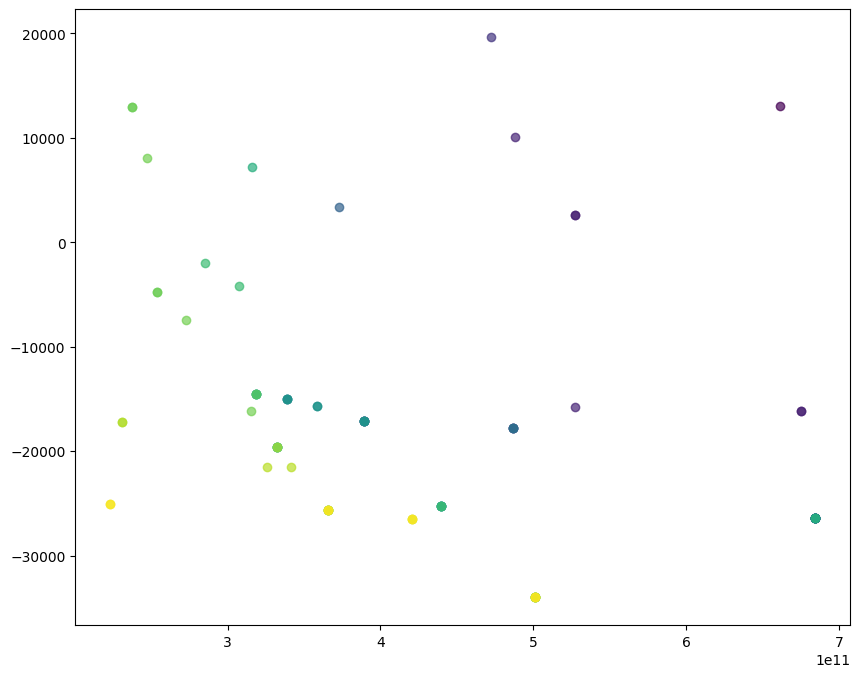

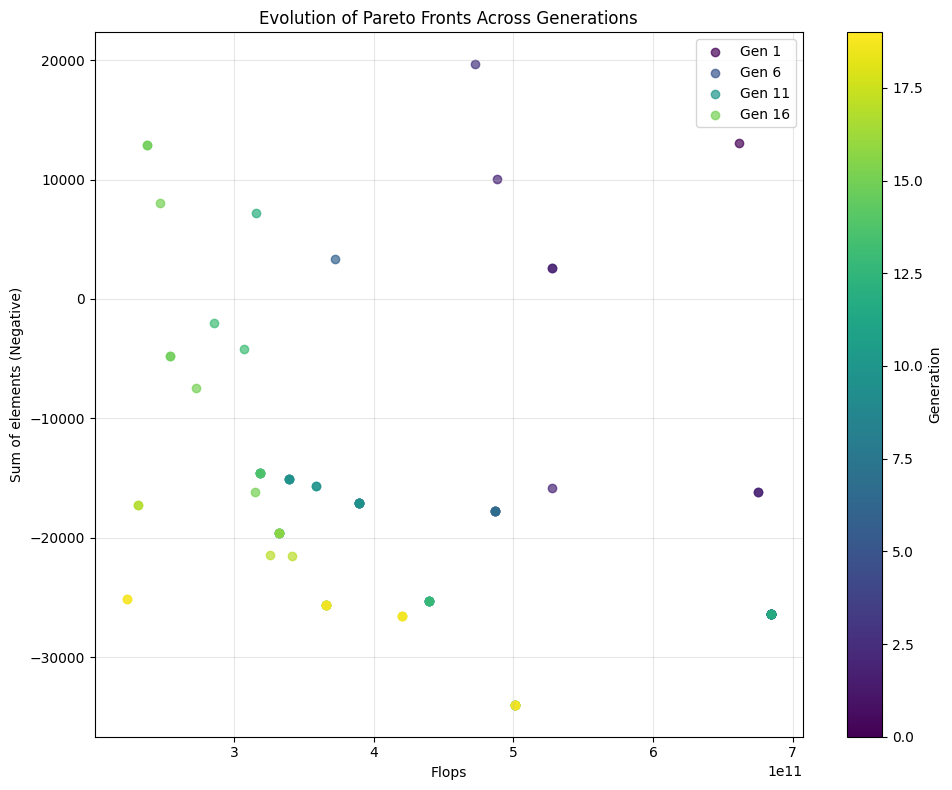

In [14]:
plot_all_pareto_fronts()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from thop import profile

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool2d(x, (8, 8))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define model and move to GPU
model = SimpleModel().cuda()

# Generate a random input tensor (batch size 1, 3 channels, 32x32 image) and move to GPU
input_tensor = torch.randn(1, 3, 512, 512).cuda()

# Compute FLOPs and parameters
with torch.no_grad():
    flops, params = profile(model, inputs=(input_tensor,))
    
    # Forward pass to get output
    output = model(input_tensor)
    
    # Sum of elements in output
    output_sum = output.sum().item()

print(f"FLOPs: {flops}")
print(f"Sum of elements in output: {output_sum}")
